# Exercise 5.1

## 5.1a) Deep Q-Learning

In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
class ConfigurableMLP(nn.Module):
    def __init__(self, config):
        super(ConfigurableMLP, self).__init__()
        layers = []
        input_size = config['input_size']
        
        for layer_idx, hidden_size in enumerate(config['hidden_sizes']):
            layers.append(nn.Linear(input_size, hidden_size))
            activation = config['activations'][layer_idx]
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'none':  # No activation
                pass
            else:
                raise ValueError(f"Unsupported activation: {activation}")

            input_size = hidden_size
        
        # Final output layer
        layers.append(nn.Linear(input_size, config['output_size']))
        final_activation = config.get('final_activation', 'none')
        if final_activation == 'softmax':
            layers.append(nn.Softmax(dim=1))
        elif final_activation == 'none':
            pass
        else:
            raise ValueError(f"Unsupported activation: {final_activation}")
        
        self.network = nn.Sequential(*layers)

        print(self)


    def forward(self, x):
        return self.network(x)


In [5]:
class QNetwork:
    def __init__(self, n_input_features, n_actions: int, learning_rate: float = 0.0001):
        """Initializes the neural network for the action-value function"""
        config = {
            'input_size': n_input_features,
            'hidden_sizes': [64, 32],
            'output_size': n_actions,
            'activations': ['relu', 'relu'],
            'final_activation': 'none'
        }
        self.model = ConfigurableMLP(config)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def get_value(self, state, action) -> float:
        """Returns the value of the given state-action pair"""
        state = torch.tensor(state, dtype=torch.float32)
        action_values = self.model.forward(state)
        return action_values[action].item()
    
    def get_action_values_from_state(self, state):
        """Returns the action values for a state"""
        state = torch.tensor(state, dtype=torch.float32)
        action_values = self.model.forward(state)
        return action_values.detach().numpy()

    def backward(self, state, action, target):
        """Compute one optimization step"""
        self.optimizer.zero_grad()
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self.model.forward(state)
        target_q_values = q_values.clone()
        target_q_values[action] = target
        loss = self.criterion(q_values, target_q_values)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def get_copy(self):
        """Create a copy of the value function instance."""
        return deepcopy(self)
    


In [6]:
class Actor:
    def __init__(self, num_actions: int):
        """Initialize actor with number of possible actions"""
        self.num_actions = num_actions

    def epsilon_greedy_action(self, state, epsilon, value_function):
        """Select action using epsilon-greedy strategy based on Q-values
        
        Args:
            state: Current state
            epsilon: Exploration probability
            value_function: Q-network that provides action values
        
        Returns:
            Selected action
        """
        if np.random.rand() < epsilon:
            # Exploration: random action
            return np.random.choice(self.num_actions)
        else:
            # Exploitation: best action according to Q-values
            q_values = value_function.get_action_values_from_state(state)
            return np.argmax(q_values)
        
    def greedy_action(self, state, value_function):
        """Select the best action according to Q-values"""
        q_values = value_function.get_action_values_from_state(state)
        return np.argmax(q_values)


In [7]:
class TD():
    """Collection of Temporal Difference Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: QNetwork,
        env: gym.Env,
        gamma: float = 0.8, # discount factor (how much future rewards are valued compared to immediate rewards)
        epsilon: float = 0.1,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.1,
        epsilon_decay_steps: int = 1000
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon = epsilon
        
        # Add tracking lists
        self.episode_rewards = []
        self.episode_losses = []

    def deep_q_learning(self, num_episodes: int):
        """Deep Q-Learning Off-Policy TD Control"""
        for episode in range(num_episodes):
            # Decay epsilon
            self.epsilon = max(
                self.epsilon_end,
                self.epsilon_start - (self.epsilon_start - self.epsilon_end) * 
                (episode / self.epsilon_decay_steps)
            )

            # Reset environment
            state, _ = self.env.reset()
            terminated = truncated = False
            accumulated_reward = 0 
            episode_loss = 0

            while not terminated and not truncated:
                # Select action
                action = self.actor.epsilon_greedy_action(state, self.epsilon, self.value_function)
                state_, reward, terminated, truncated, _ = self.env.step(action)
                accumulated_reward += reward 

                # Find TD target
                if terminated or truncated:
                    td_target = reward
                else:
                    best_action_ = self.actor.greedy_action(state_, self.value_function)
                    best_action_value_ = self.value_function.get_value(state_, best_action_)
                    td_target = reward + self.gamma * best_action_value_

                # Update network
                loss = self.value_function.backward(state, action, td_target)
                episode_loss += loss
                
                state = state_

            self.episode_rewards.append(accumulated_reward)
            self.episode_losses.append(episode_loss)
            if episode % 100 == 0:
                avg_loss = np.mean(self.episode_losses[-100:])
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode} completed. Epsilon: {self.epsilon:.2f}. Avg Loss (last 100): {avg_loss:.2f}. Avg Reward (last 100): {avg_reward:.2f}")

    def train_deep_q_learning(self, num_episodes: int):
        print("[Info] - Starting Deep Q-Learning Algorithm Training")
        result = self.deep_q_learning(num_episodes)
        
        # Print final statistics
        print("\nTraining completed!")
        
        return result

In [8]:
env = gym.make("CartPole-v1")
env.reset()

episodes = 5000

actor = Actor(num_actions=env.action_space.n)
value_function = QNetwork(n_input_features=env.observation_space.shape[0], n_actions=env.action_space.n, learning_rate=0.0001)
algorithm = TD(actor, value_function, env, gamma=0.99, epsilon_start=1, epsilon_end=0.01, epsilon_decay_steps=2000)

algorithm.train_deep_q_learning(episodes)


ConfigurableMLP(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
[Info] - Starting Deep Q-Learning Algorithm Training
Episode 0 completed. Epsilon: 1.00. Avg Loss (last 100): 9.77. Avg Reward (last 100): 19.00
Episode 100 completed. Epsilon: 0.95. Avg Loss (last 100): 23.27. Avg Reward (last 100): 22.14
Episode 200 completed. Epsilon: 0.90. Avg Loss (last 100): 120.40. Avg Reward (last 100): 22.03
Episode 300 completed. Epsilon: 0.85. Avg Loss (last 100): 162.28. Avg Reward (last 100): 20.29
Episode 400 completed. Epsilon: 0.80. Avg Loss (last 100): 155.26. Avg Reward (last 100): 18.98
Episode 500 completed. Epsilon: 0.75. Avg Loss (last 100): 153.65. Avg Reward (last 100): 20.78
Episode 600 completed. Epsilon: 0.70. Avg Loss (last 100): 139.20. Avg Reward (last 100): 20.39
Episode 700 completed.

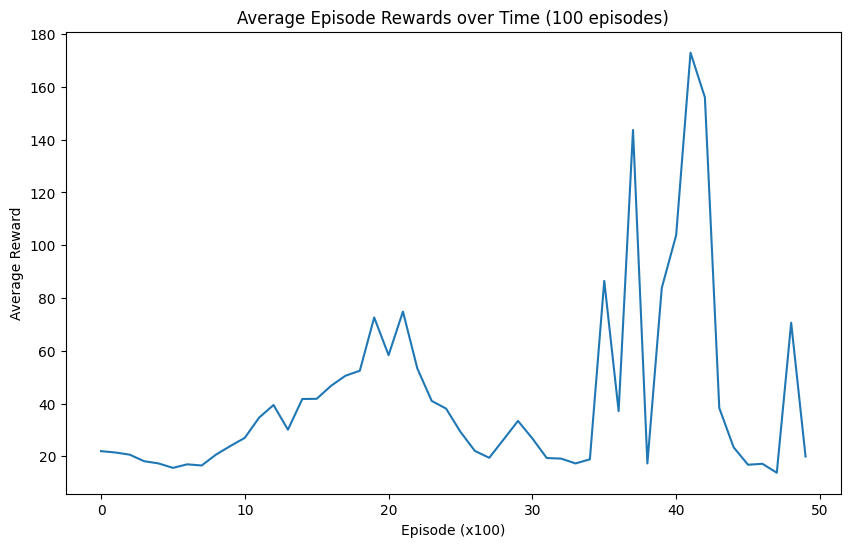

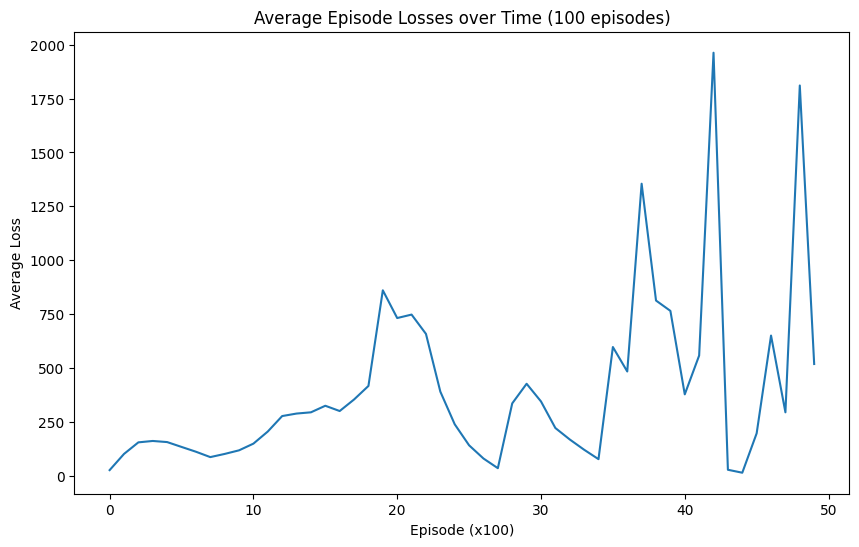

In [8]:
# Plot the average episode rewards over 100 episodes
average_rewards = [np.mean(algorithm.episode_rewards[i:i+100]) for i in range(0, len(algorithm.episode_rewards), 100)]
plt.figure(figsize=(10, 6))
# plt.plot(algorithm.episode_rewards)
plt.plot(average_rewards)
plt.title('Average Episode Rewards over Time (100 episodes)')
plt.xlabel('Episode (x100)')
plt.ylabel('Average Reward')
plt.show()

# Plot the average episode losses over 100 episodes
average_losses = [np.mean(algorithm.episode_losses[i:i+100]) for i in range(0, len(algorithm.episode_losses), 100)]
plt.figure(figsize=(10, 6))
# plt.plot(algorithm.episode_losses)
plt.plot(average_losses)
plt.title('Average Episode Losses over Time (100 episodes)')
plt.xlabel('Episode (x100)')
plt.ylabel('Average Loss')
plt.show()


Reflection:

- For visualizing the value function, we could fix the velocity of the cart and the angular velocity of the pole, and then plot the value function for the remaining two variables, namely the position of the cart and the angle of the pole.
This could help us understand the value function better, and how it changes when the cart moves or the pole tilts, where critical points are or where the value function is unstable.

## b) Extensions to the Q-Learning Algorithm

Replay Buffer and Target Network:

In [9]:
class QNetwork:
    def __init__(self, n_input_features, n_actions: int, learning_rate: float = 0.0001):
        """Initializes the neural network for the action-value function"""
        self.config = {
            'input_size': n_input_features,
            'hidden_sizes': [64, 32],
            'output_size': n_actions,
            'activations': ['relu', 'relu'],
            'final_activation': 'none'
        }
        self.model = ConfigurableMLP(self.config)
        self.target_model = ConfigurableMLP(self.config)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def get_value(self, state, action) -> float:
        """Returns the value of the given state-action pair"""
        state = torch.tensor(state, dtype=torch.float32)
        action_values = self.model.forward(state)
        return action_values[action].item()
    
    def get_action_values_from_state(self, state):
        """Returns the action values for a state"""
        state = torch.tensor(state, dtype=torch.float32)
        action_values = self.model.forward(state)
        return action_values.detach().numpy()

    def backward(self, state, action, target):
        """Compute one optimization step"""
        self.optimizer.zero_grad()
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self.model.forward(state)
        target_q_values = q_values.clone()
        target_q_values[action] = target
        loss = self.criterion(q_values, target_q_values)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def get_copy(self):
        """Create a copy of the value function instance."""
        from copy import deepcopy
        return deepcopy(self)
    


In [10]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        """Save a transition"""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Sample a batch of transitions"""
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (np.array(state), 
                np.array(action), 
                np.array(reward), 
                np.array(next_state), 
                np.array(done))
    
    def __len__(self):
        return len(self.buffer)

In [11]:
class TD():
    """Collection of Temporal Difference Algorithms for RL"""

    def __init__(
        self,
        actor: Actor,
        value_fct: QNetwork,
        env: gym.Env,
        gamma: float = 0.8,   # discount factor (how much future rewards are valued compared to immediate rewards)
        epsilon: float = 0.1, 
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.1,
        epsilon_decay_steps: int = 1000
    ):
        self.actor = actor
        self.env = env
        self.value_function = value_fct
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon = epsilon
        
        # Add tracking lists
        self.episode_rewards = []
        self.episode_losses = []
        self.steps = 0
    
    def train_deep_q_learning_with_replay_buffer(self, num_episodes: int):
        replay_buffer = ReplayBuffer(capacity=10000)
        min_buffer_size = 1000  # Start training when buffer has this many samples
        batch_size = 32
        target_update_frequency = 500
        for episode in range(num_episodes):
            # Decay epsilon
            self.epsilon = max(
                self.epsilon_end,
                self.epsilon_start - (self.epsilon_start - self.epsilon_end) * 
                (episode / self.epsilon_decay_steps)
            )

            state, _ = self.env.reset()
            terminated = truncated = False
            episode_reward = 0
            episode_loss = 0
            
            while not (terminated or truncated):
                action = self.actor.epsilon_greedy_action(state, self.epsilon, self.value_function)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                self.steps += 1
                # Store transition in replay buffer
                replay_buffer.push(state, action, reward, next_state, terminated or truncated)
                
                # Only start training when we have enough samples
                if len(replay_buffer) > min_buffer_size:
                    # Sample random batch
                    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                    
                    # Convert to tensors
                    states = torch.FloatTensor(states)
                    actions = torch.LongTensor(actions)
                    rewards = torch.FloatTensor(rewards)
                    next_states = torch.FloatTensor(next_states)
                    dones = torch.BoolTensor(dones)
                    
                    # Compute Q values
                    current_q_values = self.value_function.model(states)
                    current_q_values = current_q_values.gather(1, actions.unsqueeze(1))
                    
                    # Compute next Q values
                    next_q_values = self.value_function.target_model(next_states)
                    next_q_values = next_q_values.max(1)[0].detach()
                    
                    # Compute target Q values
                    target_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values
                    
                    # Compute loss and update
                    loss = self.value_function.criterion(current_q_values.squeeze(), target_q_values)
                    episode_loss += loss.item()
                    
                    self.value_function.optimizer.zero_grad()
                    loss.backward()
                    self.value_function.optimizer.step()

                    if self.steps % target_update_frequency == 0:
                        self.value_function.update_target_model()
                
                state = next_state
                episode_reward += reward
                        
            self.episode_rewards.append(episode_reward)
            self.episode_losses.append(episode_loss)
            if episode % 100 == 0:
                avg_loss = np.mean(self.episode_losses[-100:])
                avg_reward = np.mean(self.episode_rewards[-100:])
                print(f"Episode {episode} completed. Epsilon: {self.epsilon:.2f}. Avg Loss (last 100): {avg_loss:.2f}. Avg Reward (last 100): {avg_reward:.2f}")


In [12]:
env = gym.make("CartPole-v1")
env.reset()

episodes = 5000

actor = Actor(num_actions=env.action_space.n)
value_function = QNetwork(n_input_features=env.observation_space.shape[0], n_actions=env.action_space.n, learning_rate=0.0001)
algorithm_with_replay_buffer = TD(actor, value_function, env, gamma=0.99, epsilon_start=1, epsilon_end=0.01, epsilon_decay_steps=2000)

algorithm_with_replay_buffer.train_deep_q_learning_with_replay_buffer(episodes)


ConfigurableMLP(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
ConfigurableMLP(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)
Episode 0 completed. Epsilon: 1.00. Avg Loss (last 100): 0.00. Avg Reward (last 100): 26.00
Episode 100 completed. Epsilon: 0.95. Avg Loss (last 100): 6.96. Avg Reward (last 100): 24.03
Episode 200 completed. Epsilon: 0.90. Avg Loss (last 100): 14.08. Avg Reward (last 100): 19.23
Episode 300 completed. Epsilon: 0.85. Avg Loss (last 100): 40.75. Avg Reward (last 100): 29.39
Episode 400 completed. Epsilon: 0.80. Avg Loss (last 100): 108.87. Avg Reward (last 100): 36.59
Episode 500 

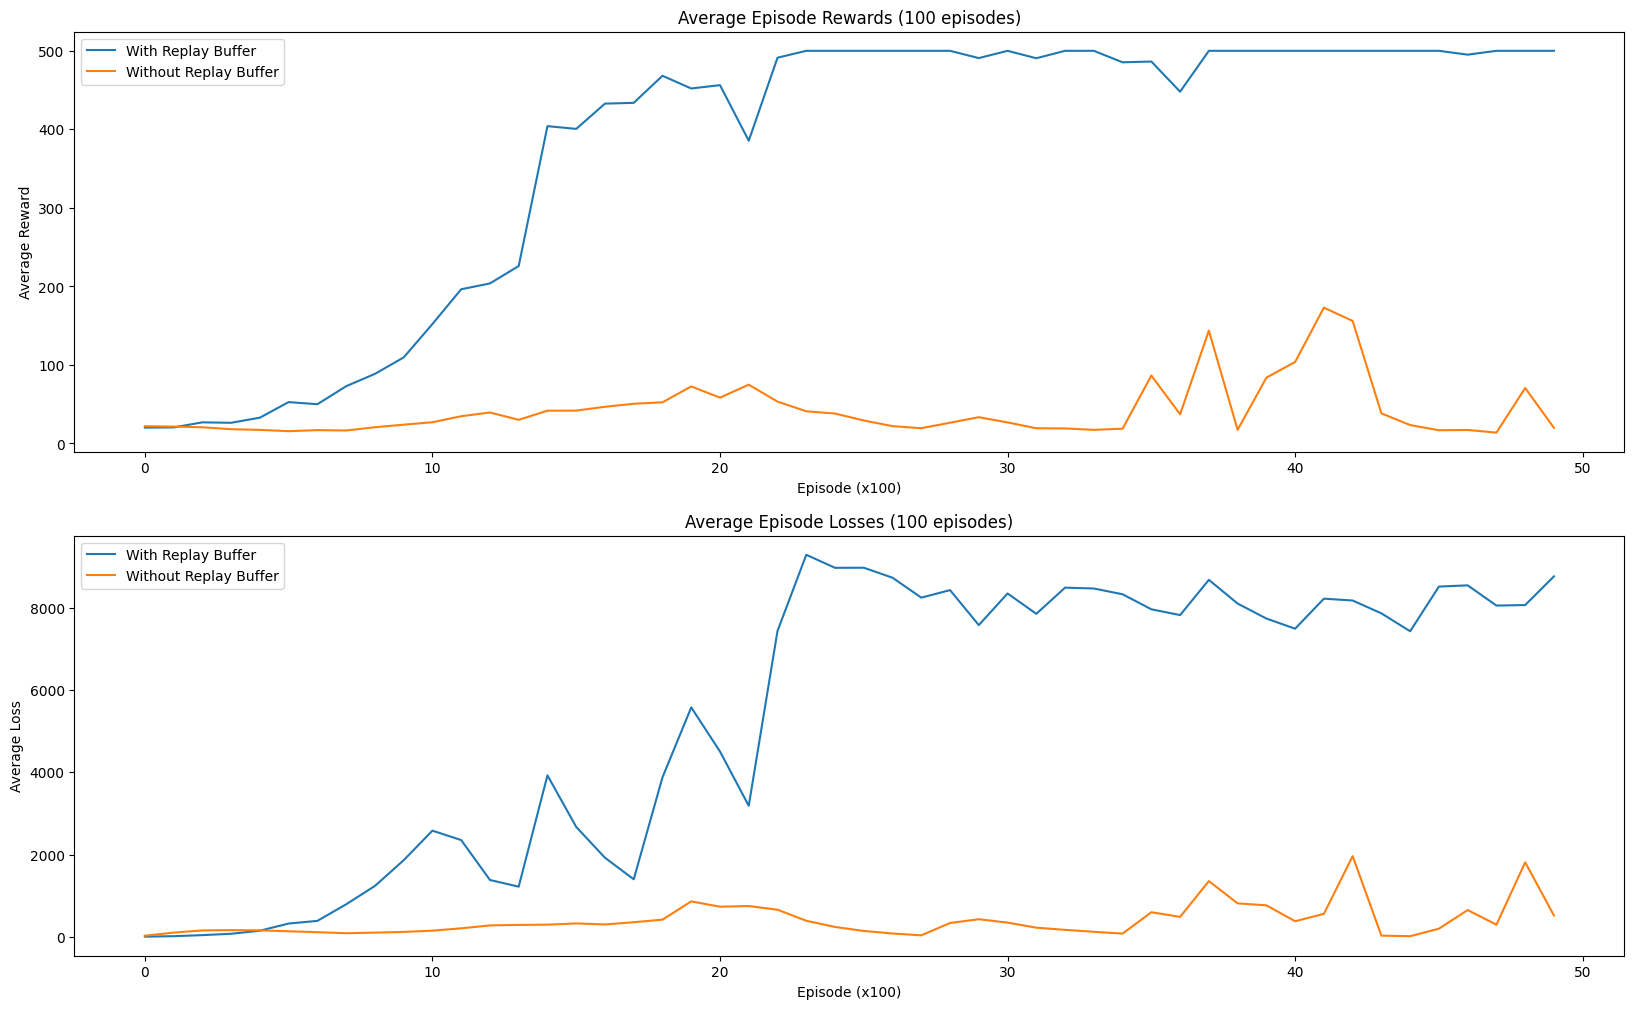

In [13]:
# Calculate the average episode rewards and losses over 100 episodes for replay buffer
average_rewards_replay_buffer = [np.mean(algorithm_with_replay_buffer.episode_rewards[i:i+100]) for i in range(0, len(algorithm_with_replay_buffer.episode_rewards), 100)]
average_losses_replay_buffer = [np.mean(algorithm_with_replay_buffer.episode_losses[i:i+100]) for i in range(0, len(algorithm_with_replay_buffer.episode_losses), 100)]

plt.figure(figsize=(20, 12))

# Plot average episode rewards
plt.subplot(2, 1, 1)
plt.plot(average_rewards_replay_buffer, label='With Replay Buffer')
plt.plot(average_rewards, label='Without Replay Buffer')
plt.title('Average Episode Rewards (100 episodes)')
plt.xlabel('Episode (x100)')
plt.ylabel('Average Reward')
plt.legend()

# Plot average episode losses
plt.subplot(2, 1, 2)
plt.plot(average_losses_replay_buffer, label='With Replay Buffer')
plt.plot(average_losses, label='Without Replay Buffer')
plt.title('Average Episode Losses (100 episodes)')
plt.xlabel('Episode (x100)')
plt.ylabel('Average Loss')
plt.legend()

plt.show()


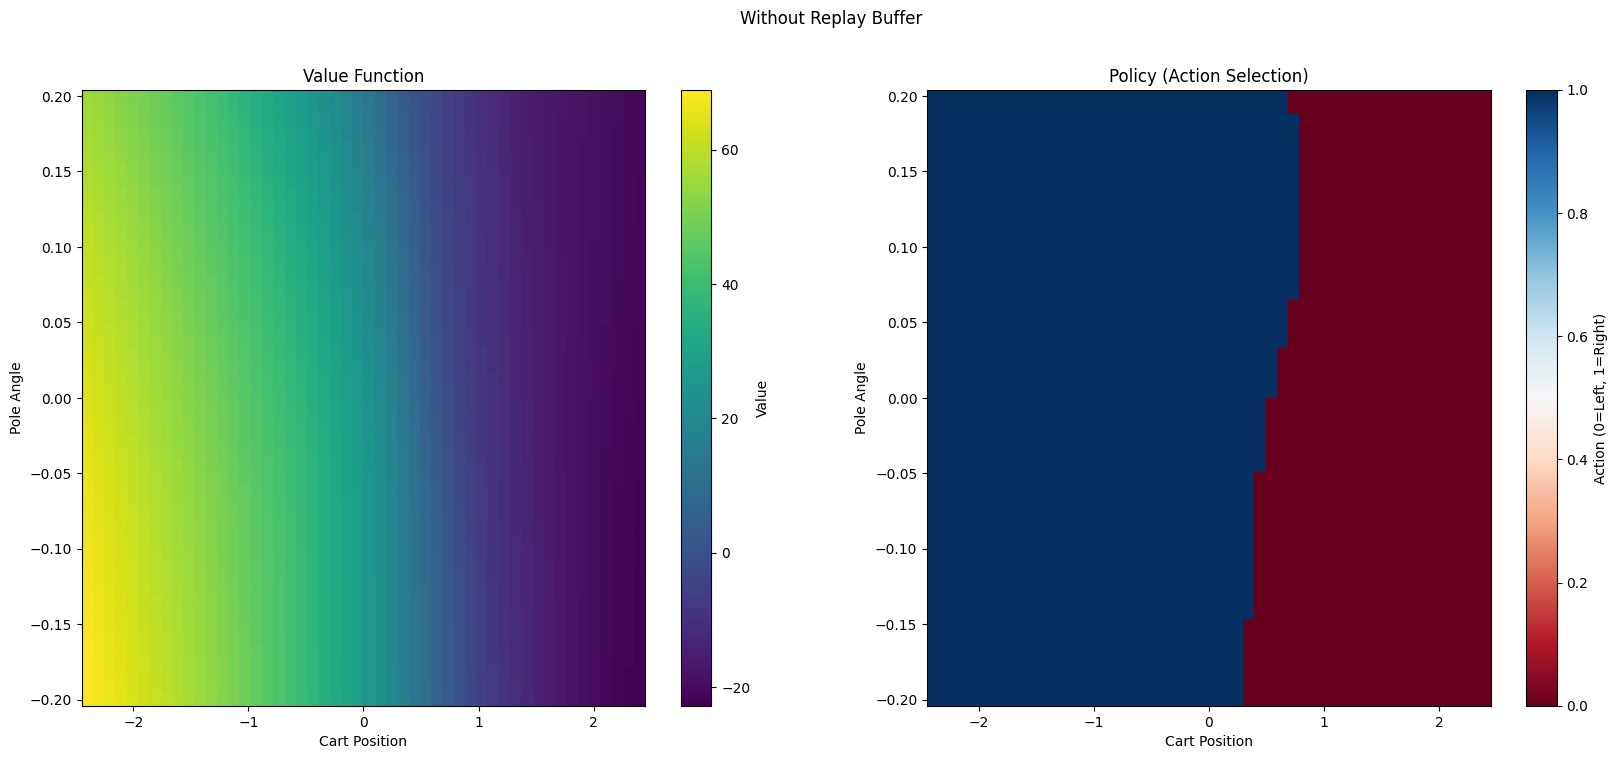

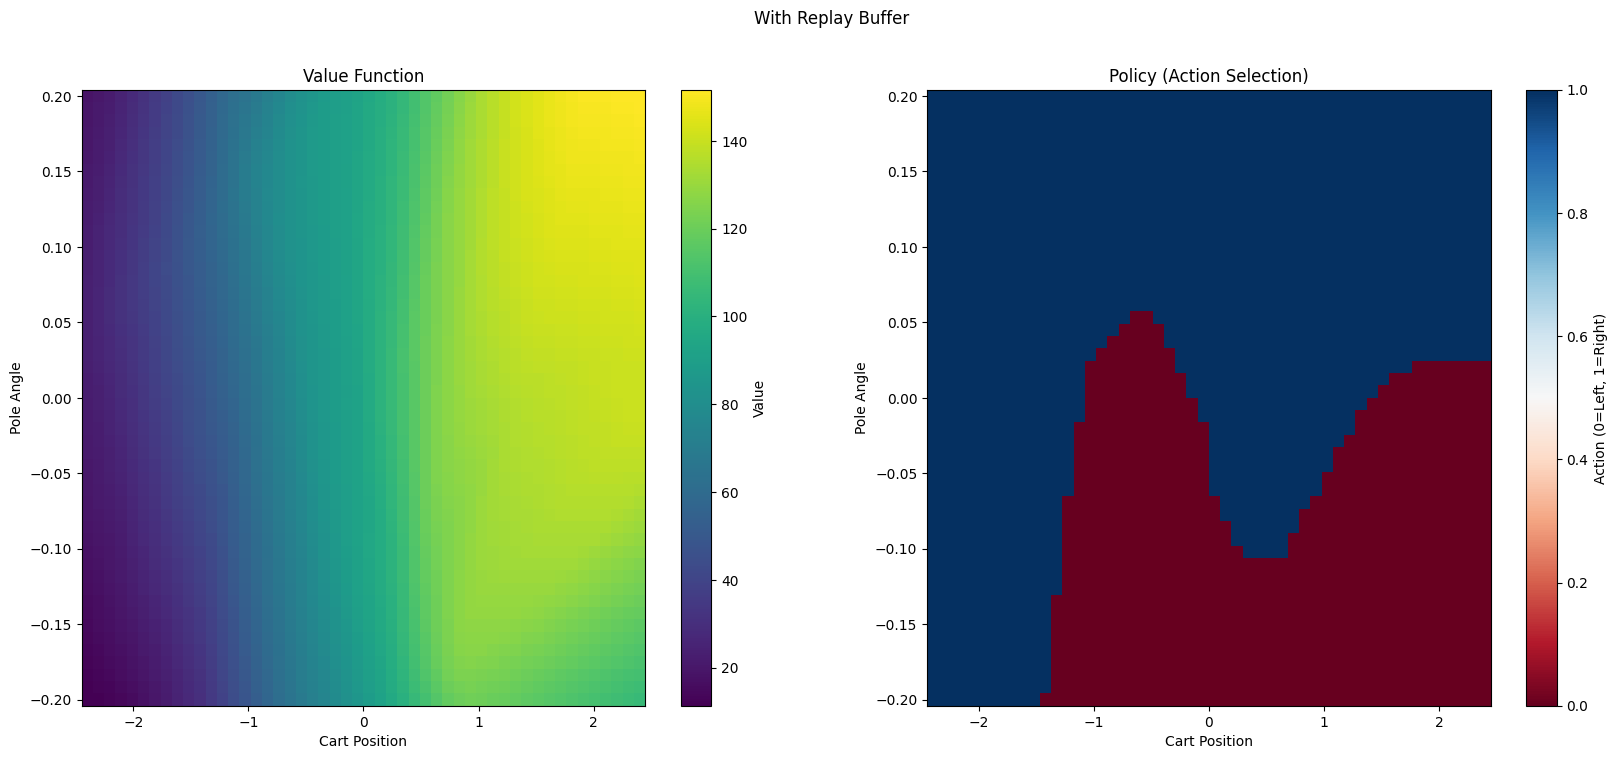

In [14]:
def visualize_value_function(value_network, title="Value Function Visualization"):
    # Create meshgrid for position and angle
    positions = np.linspace(-2.4, 2.4, 50)  # Cart position range
    angles = np.linspace(-0.2, 0.2, 50)     # Pole angle range
    X, Y = np.meshgrid(positions, angles)
    
    # Initialize matrices for values and actions
    Z = np.zeros_like(X)
    actions = np.zeros_like(X)
    
    # Fix velocities at 0
    cart_velocity = 0.0
    pole_velocity = 0.0
    
    # Calculate values for each position-angle pair
    for i in range(len(positions)):
        for j in range(len(angles)):
            state = np.array([X[i,j], cart_velocity, Y[i,j], pole_velocity])
            # Get Q-values for both actions and take max
            q_values = value_network.get_action_values_from_state(state)
            Z[i,j] = np.max(q_values)
            actions[i,j] = np.argmax(q_values)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot value function
    im1 = ax1.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar(im1, ax=ax1, label='Value')
    ax1.set_xlabel('Cart Position')
    ax1.set_ylabel('Pole Angle')
    ax1.set_title('Value Function')
    
    # Plot policy
    im2 = ax2.pcolormesh(X, Y, actions, shading='auto', cmap='RdBu', vmin=0, vmax=1)
    plt.colorbar(im2, ax=ax2, label='Action (0=Left, 1=Right)')
    ax2.set_xlabel('Cart Position')
    ax2.set_ylabel('Pole Angle')
    ax2.set_title('Policy (Action Selection)')
    
    plt.suptitle(title)
    plt.show()

# Use for both networks
visualize_value_function(algorithm.value_function, "Without Replay Buffer")
visualize_value_function(algorithm_with_replay_buffer.value_function, "With Replay Buffer")

Reflection: 

- The introduction of function approximation enables the algorithm to do Q-Learning even in situations where the state space is really large or continuous, which poses a lot of problems for tabular solutions. Therefore, the algorithm is able to adapt to more complicated environments. 
- By introducing a decaying epsilon strategy, the algorithm has time to explore the environment before then converging on the learned policy. With function approximation, the algorithm still explores when having explored enough, which leads to problems with stability. 
- This problem can be adressed with a replay buffer, which helps stabilize the resulting Q-Network, since it doesnt learn on correlated data, which is the case when using consecutive samples in a regular DQN
- Also, the introduction of a target network helps to stabilize the learning process, since it reduces the variance of the updates, which can be a big problem for high gammas especially.
- These stability changes can be perceived in the graphs, where the average loss and reward are more stable when using a replay buffer and a target network, and of course the advanced algorithm converges to a almost perfect policy. 
